### Import thư viện

In [2]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout  # type: ignore
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

/Users/phongtran/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Tạo dữ liệu giả

In [3]:
# Number of samples
n_samples = 1000000

# Initial pH value
current_pH = np.random.uniform(6.5, 7.5)  # Start within the safe range
pH_values = []

# Safe range and limits
safe_lower = 6.5
safe_upper = 7.5
absolute_lower = 1.0
absolute_upper = 10.0

# Generate pH values
for _ in range(n_samples):
    # Randomly increase or decrease by 0.1
    current_pH += np.random.choice([-0.1, 0.1])

    # Check limits
    if current_pH < absolute_lower or current_pH > absolute_upper:
        current_pH = np.clip(current_pH, absolute_lower, absolute_upper)

    # Handle safe range violations
    if current_pH < safe_lower or current_pH > safe_upper:
        if np.random.random() < 0.9:  # 90% chance to move back towards the safe range
            if current_pH < safe_lower:
                current_pH += 0.01
            elif current_pH > safe_upper:
                current_pH -= 0.01

    # Ensure pH remains within absolute limits
    current_pH = np.clip(current_pH, absolute_lower, absolute_upper)
    pH_values.append(current_pH)

# Generate DO (Dissolved Oxygen) values (similar random fluctuations)
DO_values = []
current_DO = np.random.uniform(3.0, 7.0)
for _ in range(n_samples):
    current_DO += np.random.uniform(-0.2, 0.2)
    current_DO = np.clip(current_DO, 0.0, 10.0)
    DO_values.append(current_DO)

# Calculate pump time
water_volume = 1000  # Fixed water volume in liters
pump_flow_rate = 10  # Flow rate in liters per second
adjustment_factor = 0.5
pump_times = []

for pH in pH_values:
    if pH < safe_lower:
        time = adjustment_factor * \
            (safe_lower - pH) * water_volume / pump_flow_rate
    elif pH > safe_upper:
        time = adjustment_factor * \
            (pH - safe_upper) * water_volume / pump_flow_rate
    else:
        time = 0
    pump_times.append(time)

# Create a DataFrame
data = {
    "pH": pH_values,
    "DO": DO_values,
    "Pump Time (s)": pump_times
}
df = pd.DataFrame(data)

# Save to CSV
file_path = "./simulated_pH_data.csv"
df.to_csv(file_path, index=False)

file_path

'./simulated_pH_data.csv'

### Tiền xử lý dữ liệu

Dữ liệu không có giá trị bị thiếu.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   pH      1000000 non-null  float64
dtypes: float64(1)
memory usage: 7.6 MB
None
                   pH
count  1000000.000000
mean         0.500411
std          0.174018
min          0.000000
25%          0.386005
50%          0.498871
75%          0.611738
max          1.000000


Text(0.5, 0, 'Thời gian')

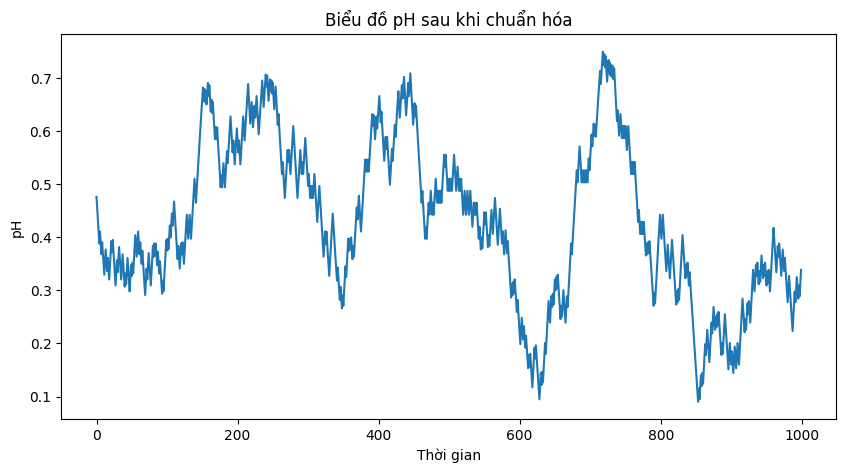

In [4]:
from sklearn.preprocessing import MinMaxScaler
# path = "/Users/phongtran/Downloads/simulated_pH_data.csv"
path = "./simulated_pH_data.csv"

# Cấu hình
cols = ['pH']
df = pd.read_csv(path)

# Chỉ lấy các cột cần thiết
df = df[cols]

# Xử lý giá trị bất thường (outliers)
for col in cols:
    outliers = df[(df[col] < df[col].quantile(0.01)) |
                  (df[col] > df[col].quantile(0.99))]
    if len(outliers) > 0:
        df[col] = np.where(
            (df[col] < df[col].quantile(0.01)) | (
                df[col] > df[col].quantile(0.99)),
            df[col].median(),
            df[col]
        )

# Xử lý giá trị thiếu (NaN)
if df.isnull().sum().sum() > 0:
    print("Dữ liệu có giá trị bị thiếu. Tiến hành xử lý...")
    df = df.fillna(df.mean())  # Sửa lỗi inplace=True
else:
    print("Dữ liệu không có giá trị bị thiếu.")

# Chuẩn hóa dữ liệu bằng MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)  # Scale chỉ các cột số, không có Date

# Chuyển kết quả về DataFrame và giữ nguyên tên cột
scaled_df = pd.DataFrame(scaled_data, columns=cols)

# Kiểm tra thông tin dữ liệu
print(scaled_df.info())  # Kiểm tra kiểu dữ liệu và giá trị null
print(scaled_df.describe())

# Vẽ biểu đồ kiểm tra dữ liệu
plt.figure(figsize=(10, 5))
sns.lineplot(scaled_df['pH'][0:1000])
plt.title("Biểu đồ pH sau khi chuẩn hóa")
plt.xlabel("Thời gian")

### Tạo chuỗi dữ liệu và chia tập dữ liệu huấn luyện

In [5]:
def create_sequences(data, look_back=30):
    """
    Tạo chuỗi thời gian cho mô hình.
    - data: Dữ liệu đã chuẩn hóa (numpy array).
    - look_back: Số bước thời gian trước đó để làm đầu vào.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])  # Tất cả cột
        y.append(data[i + look_back, 0])  # cột dầu tiên
    return np.array(X), np.array(y)


# Chia dữ liệu thành tập train/test
train_size = int(len(scaled_data) * 0.8)  # 80% cho train, 20% cho test
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Tạo chuỗi dữ liệu
look_back = 20  # Độ dài chuỗi
X_train, y_train = create_sequences(train, look_back)
X_test, y_test = create_sequences(test, look_back)

# Định hình lại input cho CNN-LSTM: [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

print("Shape của X_train:", X_train.shape)
print("Shape của y_train:", y_train.shape)
print("Shape của X_test:", X_test.shape)
print("Shape của y_test:", y_test.shape)


# Kiểm tra NaN sau khi xử lý
print("Kiểm tra giá trị NaN trong dữ liệu đã xử lý...")
if np.isnan(X_train).sum() > 0 or np.isnan(X_test).sum() > 0:
    print("Có giá trị NaN trong dữ liệu sau khi xử lý.")
else:
    print("Không có giá trị NaN trong dữ liệu. Dữ liệu đã sạch.")

Shape của X_train: (799980, 20, 1)
Shape của y_train: (799980,)
Shape của X_test: (199980, 20, 1)
Shape của y_test: (199980,)
Kiểm tra giá trị NaN trong dữ liệu đã xử lý...
Không có giá trị NaN trong dữ liệu. Dữ liệu đã sạch.


### Xây dựng mô hình

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Xây dựng mô hình
model = Sequential()

# Lớp CNN
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
          input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Lớp LSTM
model.add(LSTM(100, return_sequences=True))  # Trả về chuỗi đầu ra
model.add(Dropout(0.3))
# Lớp LSTM cuối không cần trả về chuỗi
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))

# Dense Layer
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # Đầu ra 1 giá trị pH

# Compile mô hình
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(model.summary())
model.save('test-3.h5')

/Users/phongtran/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 9, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 9, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,057 (386.94 KB)

 Trainable params: 99,057 (386.94 KB)

 Non-trainable params: 0 (0.00 B)

None


### Huấn luyện mô hình với lr động

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Callback để tự động lưu mô hình tốt nhất
checkpoint = ModelCheckpoint(
    'best_model.h5',  # Tên tệp lưu
    monitor='val_loss',  # Theo dõi validation loss
    save_best_only=True,  # Chỉ lưu khi val_loss giảm
    mode='min'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Theo dõi validation loss
    factor=0.5,          # Giảm learning rate đi 50%
    patience=4,          # Nếu val_loss không giảm trong 5 epochs thì giảm lr
    min_lr=1e-6          # Không giảm lr xuống thấp hơn 0.000001
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, checkpoint],  # Thêm ReduceLROnPlateau vào callback
    verbose=1
)

Epoch 1/10
24997/25000 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mae: 0.0371

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 223s 9ms/step - loss: 0.0033 - mae: 0.0371 - val_loss: 0.0017 - val_mae: 0.0276 - learning_rate: 0.0010
Epoch 2/10
24998/25000 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mae: 0.0285

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 209s 8ms/step - loss: 0.0018 - mae: 0.0285 - val_loss: 0.0014 - val_mae: 0.0253 - learning_rate: 0.0010
Epoch 3/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 205s 8ms/step - loss: 0.0017 - mae: 0.0277 - val_loss: 0.0016 - val_mae: 0.0271 - learning_rate: 0.0010
Epoch 4/10
24999/25000 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mae: 0.0273

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 219s 9ms/step - loss: 0.0016 - mae: 0.0273 - val_loss: 0.0014 - val_mae: 0.0248 - learning_rate: 0.0010
Epoch 5/10
24995/25000 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mae: 0.0270

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 218s 9ms/step - loss: 0.0016 - mae: 0.0270 - val_loss: 0.0014 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 6/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 205s 8ms/step - loss: 0.0016 - mae: 0.0265 - val_loss: 0.0015 - val_mae: 0.0256 - learning_rate: 0.0010
Epoch 7/10
24994/25000 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mae: 0.0260

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 217s 9ms/step - loss: 0.0015 - mae: 0.0260 - val_loss: 0.0013 - val_mae: 0.0246 - learning_rate: 5.0000e-04
Epoch 8/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 224s 9ms/step - loss: 0.0015 - mae: 0.0258 - val_loss: 0.0013 - val_mae: 0.0246 - learning_rate: 5.0000e-04
Epoch 9/10
24994/25000 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae: 0.0257

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 216s 9ms/step - loss: 0.0014 - mae: 0.0257 - val_loss: 0.0013 - val_mae: 0.0246 - learning_rate: 5.0000e-04
Epoch 10/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 220s 9ms/step - loss: 0.0014 - mae: 0.0256 - val_loss: 0.0013 - val_mae: 0.0247 - learning_rate: 5.0000e-04


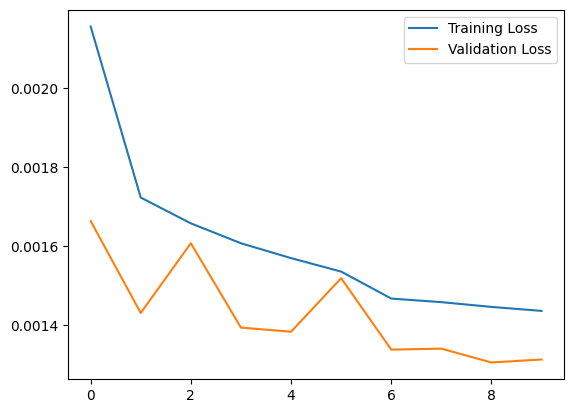

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Kiểm tra mô hình

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
(199980,)


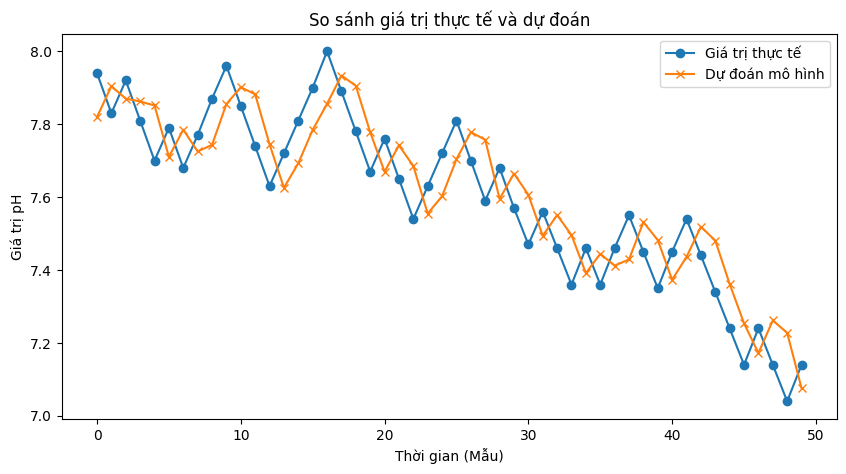

🔹 MAE (Mean Absolute Error): 0.1094
🔹 MSE (Mean Squared Error): 0.0258


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Dự đoán trên tập Validation
y_pred_val = model.predict(X_test)
print(y_test.shape)
# Chuyển đổi dữ liệu trở lại thang đo ban đầu (nếu đã chuẩn hóa)
y_val_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_val_original = scaler.inverse_transform(y_pred_val)


# Chọn một số lượng nhỏ điểm để vẽ (ví dụ: 50 điểm đầu tiên)
num_samples = 50

plt.figure(figsize=(10, 5))
plt.plot(y_val_original[:num_samples], label='Giá trị thực tế', marker='o')
plt.plot(y_pred_val_original[:num_samples],
         label='Dự đoán mô hình', marker='x')

plt.title("So sánh giá trị thực tế và dự đoán")
plt.xlabel("Thời gian (Mẫu)")
plt.ylabel("Giá trị pH")
plt.legend()
plt.show()


mae = mean_absolute_error(y_val_original, y_pred_val_original)
mse = mean_squared_error(y_val_original, y_pred_val_original)

print(f"🔹 MAE (Mean Absolute Error): {mae:.4f}")
print(f"🔹 MSE (Mean Squared Error): {mse:.4f}")
# # Sai số tuyệt đối
# errors = np.abs(y_test - y_pred_val)

# # Tính phần trăm mẫu có sai số <= 0.1
# accuracy = np.sum(errors <= 0.1) / len(errors) * 100

# print(f"Tỷ lệ mẫu có sai số <= 0.1: {accuracy:.2f}%")

### Thực hiện dự đoán

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/3c/w75xnj5d0wldwp8vnccdt3gm0000gn/T/ipykernel_85826/3948524117.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  future_sequence[0, -1, 0] = next_pred  # Thêm giá trị mới vào cuối chuỗi


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
🔮 Dự đoán 10 giá trị tiếp theo:
[[5.681977 ]
 [5.7157755]
 [5.7032595]
 [5.716309 ]
 [5.696128 ]
 [5.6944757]
 [5.6761813]
 [5.6673193]
 [5.654174 ]
 [5.645907 ]]


<Axes: >

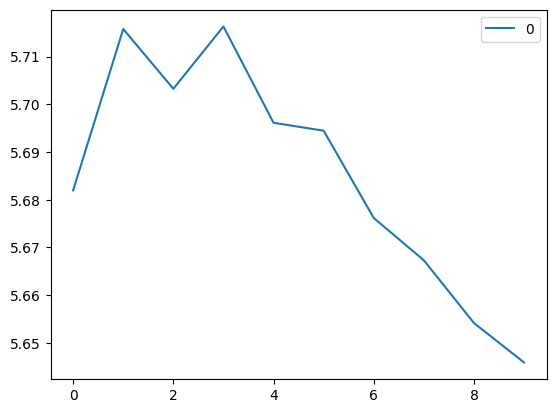

In [15]:

# Sao chép chuỗi dữ liệu cuối cùng từ tập validation
future_sequence = X_test[-1].copy().reshape(1,
                                            # Lấy mẫu cuối cùng
                                            X_test.shape[1], X_test.shape[2])

# Danh sách lưu kết quả dự đoán
future_predictions = []

# Dự đoán 10 bước tiếp theo
num_future_steps = 10

for _ in range(num_future_steps):
    # Dự đoán bước tiếp theo
    next_pred = model.predict(future_sequence)

    # Lưu giá trị dự đoán
    future_predictions.append(next_pred[0, 0])  # Chỉ lấy giá trị scalar

    # Cập nhật chuỗi dữ liệu: bỏ điểm đầu, thêm giá trị mới vào cuối
    # Dịch dữ liệu sang trái
    future_sequence = np.roll(future_sequence, shift=-1, axis=1)
    future_sequence[0, -1, 0] = next_pred  # Thêm giá trị mới vào cuối chuỗi

# Chuyển kết quả dự đoán về thang đo gốc nếu dữ liệu đã được chuẩn hóa
future_predictions_original = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1))

# Hiển thị kết quả dự đoán
print("🔮 Dự đoán 10 giá trị tiếp theo:")
print(future_predictions_original)
sns.lineplot(future_predictions_original)